<a href="https://colab.research.google.com/github/cwattsnogueira/rating-predictor-spam-detection-review-summarizer/blob/main/11_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_parquet("/content/engineered_features.parquet")
structured_features = joblib.load("/content/feature_names.json")

X_structured = df[structured_features]
print("Structured input shape:", X_structured.shape)

Structured input shape: (9480, 18)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_structured)

In [ ]:
iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_model.fit(X_scaled)

df['isolation_score'] = iso_model.decision_function(X_scaled)
df['isolation_flag'] = iso_model.predict(X_scaled)  # -1 = anomaly, 1 = normal
df['isolation_flag'] = df['isolation_flag'].map({1: 0, -1: 1})  # Convert to binary

In [ ]:
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_model.fit(X_scaled)

df['svm_score'] = svm_model.decision_function(X_scaled)
df['svm_flag'] = svm_model.predict(X_scaled)  # -1 = anomaly, 1 = normal
df['svm_flag'] = df['svm_flag'].map({1: 0, -1: 1})

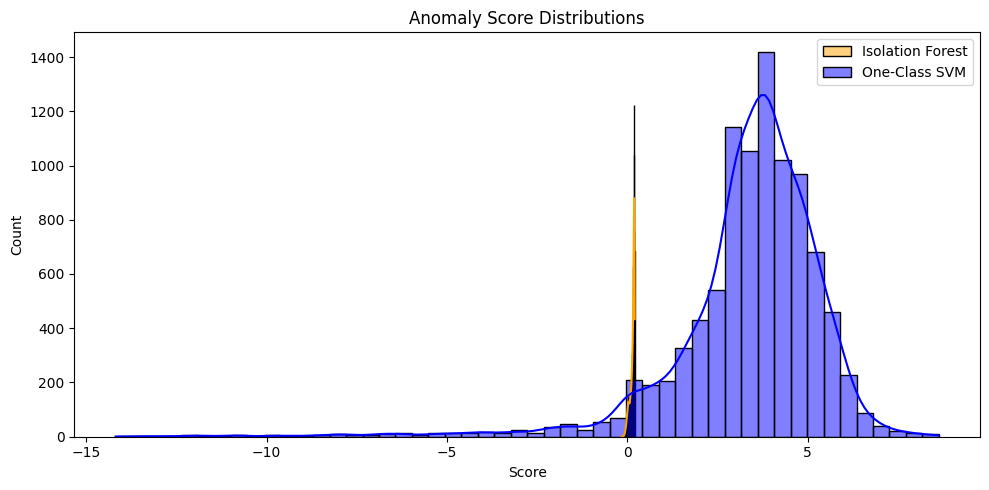

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['isolation_score'], bins=50, kde=True, color='orange', label='Isolation Forest')
sns.histplot(df['svm_score'], bins=50, kde=True, color='blue', label='One-Class SVM')
plt.title("Anomaly Score Distributions")
plt.xlabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df['anomaly_agreement'] = (df['isolation_flag'] == df['svm_flag']).astype(int)
print("Agreement between models:\n", df['anomaly_agreement'].value_counts())

Agreement between models:
 anomaly_agreement
1    9107
0     373
Name: count, dtype: int64


In [ ]:
# flag if either model detects anomaly
df['anomaly_flag_combined'] = ((df['isolation_flag'] + df['svm_flag']) > 0).astype(int)

In [ ]:
df[['id', 'isolation_flag', 'svm_flag', 'anomaly_flag_combined']].to_parquet("/content/anomaly_flags.parquet", index=False)
joblib.dump(iso_model, "/content/isolation_forest_model.pkl")
joblib.dump(svm_model, "/content/one_class_svm_model.pkl")

['/content/one_class_svm_model.pkl']

In [ ]:
print("Isolation Forest flagged:", df['isolation_flag'].sum())

Isolation Forest flagged: 474


In [ ]:
print("One-Class SVM flagged:", df['svm_flag'].sum())

One-Class SVM flagged: 471


In [ ]:
print("Agreement:", df['anomaly_agreement'].value_counts())

Agreement: anomaly_agreement
1    9107
0     373
Name: count, dtype: int64


In [ ]:
df[df['anomaly_flag_combined'] == 1][['reviews.text', 'review_length', 'sentiment_polarity', 'username_dup_flag']].sample(5)

,reviews.text,review_length,sentiment_polarity,username_dup_flag
5134,ok !,1,0.500000,0
64,I buy Olay Regenerist all the time from CVS an...,29,-0.375000,0
1443,"Very minimal scent, a little goes a long way. ...",22,0.072500,0
3539,This is the best kind of shampoo and condition...,13,0.550000,1
5132,I am normally in my favoerite store weekly. I ...,16,-0.109375,0


In [ ]:
structured_features.append('anomaly_flag_combined')

In [ ]:
df[['id', 'isolation_score', 'svm_score']].to_csv("/content/anomaly_scores.csv", index=False)

In [ ]:
structured_features += ['isolation_flag', 'svm_flag', 'anomaly_flag_combined']

In [ ]:
df[df['anomaly_agreement'] == 0][['reviews.text', 'review_length', 'sentiment_polarity']].sample(10)

,reviews.text,review_length,sentiment_polarity
3366,PANTENE Expert Pro-V AgeDefy conditioner reall...,52,0.443723
1363,Fresh and clean face,3,0.333333
3892,#NAME?,1,0.000000
705,I have used windex for many years (only becaus...,36,0.066667
6025,"The chili is great on a hotdog, but it doesn't...",8,0.900000
3905,I was looking for an Annual Budget Planner Sys...,112,0.372556
821,I have always found Windex to be one of the be...,11,1.000000
6038,Hormel chili is a great chili for those lookin...,27,0.550000
4199,We have used the Hoover Platinum Collection Li...,106,0.192544
706,Why did they change the formula it's awful . I...,35,-0.566667


<Axes: xlabel='anomaly_flag_combined', ylabel='review_length'>

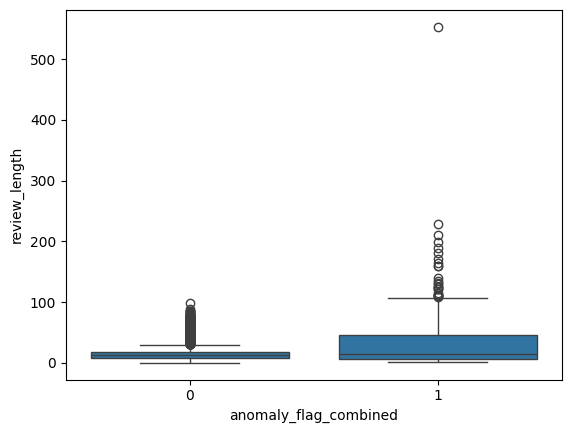

In [ ]:
sns.boxplot(x='anomaly_flag_combined', y='review_length', data=df)

In [ ]:
df[df['anomaly_flag_combined'] == 1][['id', 'reviews.text', 'review_length', 'sentiment_polarity']].to_csv("/content/anomalous_reviews.csv", index=False)

In [ ]:
# Save full DataFrame with anomaly flags
df.to_parquet("/content/engineered_features_with_anomalies.parquet", index=False)

# Save updated feature list
joblib.dump(structured_features, "/content/feature_names_with_anomalies.json")

# Save scaler (optional)
joblib.dump(scaler, "/content/structured_scaler.pkl")

['/content/structured_scaler.pkl']